# U-Net

## Hyperparameters

In [1]:
DATASET_NAME = "oxford_flowers102"
IMAGE_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 32
FILTERS = 16
PATIENCE = 8
DEPTH = 4
ALPHA = 1 - 0.125

## Load the Dataset

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

tf.keras.utils.set_random_seed(0)

dataset: dict[str, tf.data.Dataset] = tfds.load(DATASET_NAME)


def add_noise(image: tf.Tensor) -> tf.Tensor:
    noise = tf.random.normal(image.shape)
    return tf.math.sqrt(ALPHA) * image + (1 - ALPHA) * noise


def preprocess_data(data: dict[str, tf.Tensor]) -> tuple[tf.Tensor, tf.Tensor]:
    image = data["image"]
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0
    return add_noise(image), image


def preprocess_dataset(dataset: tf.data.Dataset) -> tf.data.Dataset:
    return dataset.map(preprocess_data).batch(BATCH_SIZE, drop_remainder=True)


train = preprocess_dataset(dataset["train"])
test = preprocess_dataset(dataset["test"])
validation = preprocess_dataset(dataset["validation"])

/home/melidon/egyetem/msc/2_felev/melytanulas/nhf/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-15 01:43:27.094027: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-15 01:43:27.143179: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 01:43:27.143212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 01:43:27.143250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register 

## Create the U-Net Model

In [3]:
def create_u_net(depth: int) -> tf.keras.Model:
    input_layer = tf.keras.layers.Input(
        shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )
    conv1 = tf.keras.layers.Conv2D(
        FILTERS,
        (3, 3),
        activation=tf.keras.activations.relu,
        padding="same",
    )(input_layer)
    conv2 = tf.keras.layers.Conv2D(
        FILTERS,
        (3, 3),
        activation=tf.keras.activations.relu,
        padding="same",
    )(conv1)

    encoder_list = [conv2]

    for i in range(1, depth + 1):
        max_pooling = tf.keras.layers.MaxPooling2D((2, 2))(encoder_list[i - 1])
        conv3 = tf.keras.layers.Conv2D(
            FILTERS * 2**i,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        )(max_pooling)
        conv4 = tf.keras.layers.Conv2D(
            FILTERS * 2**i,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        )(conv3)
        encoder_list.append(conv4)

    decoder_list = [encoder_list[depth]]

    for i in reversed(range(depth)):
        up_sampling = tf.keras.layers.UpSampling2D((2, 2))(
            decoder_list[depth - (i + 1)]
        )
        conv5 = tf.keras.layers.Conv2D(  # I don't know how to crop so I use Conv2D to halve the number of channels
            FILTERS * 2**i,
            (1, 1),
        )(
            up_sampling
        )
        added = tf.keras.layers.Add()([conv5, encoder_list[i]])
        conv6 = tf.keras.layers.Conv2DTranspose(
            FILTERS * 2**i,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        )(added)
        conv7 = tf.keras.layers.Conv2DTranspose(
            FILTERS * 2**i,
            (3, 3),
            activation=tf.keras.activations.relu,
            padding="same",
        )(conv6)
        decoder_list.append(conv7)

    output_layer = tf.keras.layers.Conv2D(
        3,
        (1, 1),
        activation=tf.keras.activations.sigmoid,
    )(decoder_list[depth])

    u_net = tf.keras.models.Model(input_layer, output_layer)
    u_net.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanSquaredError(),
    )

    return u_net


u_net = create_u_net(DEPTH)

## Train the U-Net Model

In [4]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="u_net.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    mode="min",
)

history = u_net.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        early_stopping_callback,
    ],
    validation_data=validation,
)

Epoch 1/32
15/15 [==============================] - 69s 4s/step - loss: 0.0737 - val_loss: 0.0459
Epoch 2/32
15/15 [==============================] - 63s 4s/step - loss: 0.0367 - val_loss: 0.0313
Epoch 3/32
15/15 [==============================] - 63s 4s/step - loss: 0.0275 - val_loss: 0.0210
Epoch 4/32
15/15 [==============================] - 62s 4s/step - loss: 0.0176 - val_loss: 0.0193
Epoch 5/32
15/15 [==============================] - 63s 4s/step - loss: 0.0135 - val_loss: 0.0111
Epoch 6/32
15/15 [==============================] - 62s 4s/step - loss: 0.0098 - val_loss: 0.0086
Epoch 7/32
15/15 [==============================] - 62s 4s/step - loss: 0.0076 - val_loss: 0.0065
Epoch 8/32
15/15 [==============================] - 62s 4s/step - loss: 0.0062 - val_loss: 0.0061
Epoch 9/32
15/15 [==============================] - 62s 4s/step - loss: 0.0058 - val_loss: 0.0055
Epoch 10/32
15/15 [==============================] - 62s 4s/step - loss: 0.0055 - val_loss: 0.0056
Epoch 11/32
15/15 [

## Visualize Train and Validation Loss

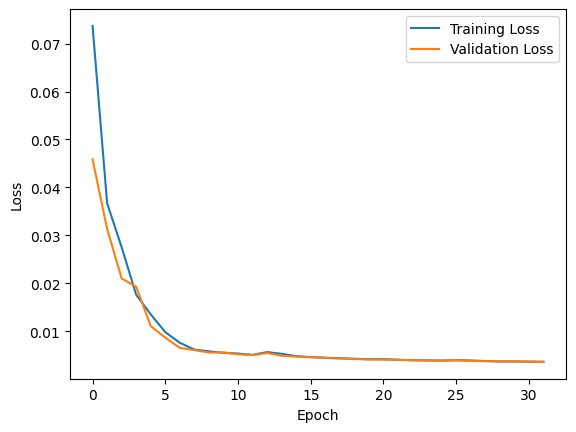

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

## Visualize the Results

1/1 [==============================] - 1s 568ms/step


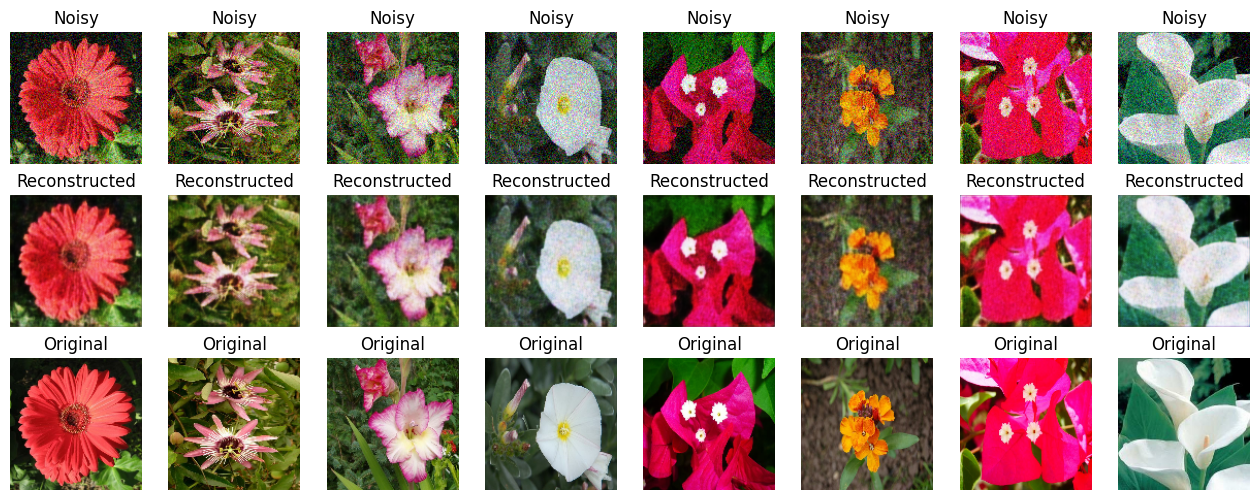

In [6]:
NUMBER_OF_IMAGES = 8
ROWS = 3

u_net.load_weights("u_net.h5")
noisy_images, original_images = next(iter(test.unbatch().batch(NUMBER_OF_IMAGES)))
reconstructed_images = u_net.predict(noisy_images)

plt.figure(figsize=(2 * NUMBER_OF_IMAGES, 2 * ROWS))
for i in range(NUMBER_OF_IMAGES):
    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 0 * NUMBER_OF_IMAGES + 1)
    plt.imshow(noisy_images[i])
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 1 * NUMBER_OF_IMAGES + 1)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.subplot(ROWS, NUMBER_OF_IMAGES, i + 2 * NUMBER_OF_IMAGES + 1)
    plt.imshow(original_images[i])
    plt.title("Original")
    plt.axis("off")

plt.show()